# Accommodating sensitivity to differences in device

Two different recorders were used in the field, the Song Meter 2 and the Song Meter 3. Recorders 1-7 were the SM3, and recorders 9-16 were the SM2.

In [1]:
import os
import sys
from pathlib import Path
project_dir = Path().resolve().parent.parent
sys.path.append(str(project_dir))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

assets_dir = project_dir / 'docs' / 'assets'

In [2]:
import einops
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import matplotlib as mpl
import torch
import librosa

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from librosa import display as libd
from umap import UMAP

from soundscape_vae.models.artefact import load_model_artefact, download_artefact
from soundscape_vae.sketch import plot_feature_importance, plot_confusion_matrix
from soundscape_vae.utils import pairwise_feature_importance

specgram_params = dict(
    sr=48_000,
    hop_length=384,
    win_length=512,
    x_axis='time',
    y_axis='mel',
    fmin=150.0,
    fmax=15_000.0,
)

seed = 42
pl.seed_everything(seed)

Global seed set to 42


42

In [3]:
from sounding_out_torch import SoundingOutChorus

dataset = SoundingOutChorus(
    download=False,
    root=Path().home() / 'data' / 'sounding_out_chorus'
)
dataset.metadata

Using sox_io as backend for audio-loading.


file_no                  file_name         country  \
file_i                                                       
0             1  PL-09_0_20150605_0530.wav  United Kingdom   
1             2  KN-16_0_20150511_0700.wav  United Kingdom   
2             3  PL-06_0_20150604_0700.wav  United Kingdom   
3             4  KN-11_0_20150511_0545.wav  United Kingdom   
4             5  PL-13_0_20150603_0415.wav  United Kingdom   
...         ...                        ...             ...   
4720       2696  TE-06_0_20150716_1835.wav         Ecuador   
4721       2697  TE-04_1_20150723_0650.wav         Ecuador   
4722       2698  PO-11_0_20150815_1840.wav         Ecuador   
4723       2699  FS-13_0_20150806_0630.wav         Ecuador   
4724       2700  PO-13_1_20150818_0625.wav         Ecuador   

                                     name location recorder  channel  \
file_i                                                                 
0                           Plashett Wood       PL     PL09        0   
1             Knepp Estate Rewilding Area       KN     KN16        0   
2                           Plashett Wood       PL     PL06        0   
3             Knepp Estate Rewilding Area       KN     KN11        0   
4                           Plashett Wood       PL     PL13        0   
...                                   ...      ...      ...      ...   
4720             Reserva Tesoro Escondido       TE     TE06        0   
4721             Reserva Tesoro Escondido       TE     TE04        1   
4722         Puerto Quito Palm Plantation       PO     PO11        0   
4723    Isolated Reserva Tesoro Escondido       FS     FS13        0   
4724         Puerto Quito Palm Plantation       PO     PO13        1   

       dawn_dusk time_period habitat  ...                 timestamp  hour  \
file_i                                ...                                   
0           dawn        dawn     UK1  ... 2015-06-05 05:30:00+01:00     5   
1           dawn         day     UK2  ... 2015-05-11 07:00:00+01:00     7   
2           dawn         day     UK1  ... 2015-06-04 07:00:00+01:00     7   
3           dawn        dawn     UK2  ... 2015-05-11 05:45:00+01:00     5   
4           dawn        dawn     UK1  ... 2015-06-03 04:15:00+01:00     4   
...          ...         ...     ...  ...                       ...   ...   
4720        dusk        dusk     EC1  ... 2015-07-17 00:35:00+01:00    18   
4721        dawn         day     EC1  ... 2015-07-23 12:50:00+01:00     6   
4722        dusk        dusk     EC3  ... 2015-08-16 00:40:00+01:00    18   
4723        dawn        dawn     EC2  ... 2015-08-06 12:30:00+01:00     6   
4724        dawn        dawn     EC3  ... 2015-08-18 12:25:00+01:00     6   

                        time_at_sunrise                   time_at_sunset  \
file_i                                                                     
0      2015-06-05 04:49:02.561538+01:00 2015-06-05 21:07:44.002361+01:00   
1      2015-05-11 05:18:51.592312+01:00 2015-05-11 20:37:53.109373+01:00   
2      2015-06-04 04:49:39.976592+01:00 2015-06-04 21:06:46.028706+01:00   
3      2015-05-11 05:18:53.059638+01:00 2015-05-11 20:37:50.528946+01:00   
4      2015-06-03 04:50:20.928044+01:00 2015-06-03 21:05:49.515591+01:00   
...                                 ...                              ...   
4720   2015-07-16 12:18:23.993066+01:00 2015-07-17 00:26:53.935526+01:00   
4721   2015-07-23 12:18:54.781933+01:00 2015-07-24 00:27:12.774992+01:00   
4722   2015-08-15 12:18:02.682213+01:00 2015-08-16 00:24:42.385170+01:00   
4723   2015-08-06 12:19:36.296529+01:00 2015-08-07 00:26:25.320390+01:00   
4724   2015-08-18 12:17:26.418448+01:00 2015-08-19 00:24:02.421795+01:00   

              time_at_astronomical_dawn            time_at_nautical_dawn  \
file_i                                                                     
0                                   NaT 2015-06-05 02:57:19.566013+01:00   
1      2015-05-11 02:35:22.121382+01:00 2015-

In [4]:
state_dict, factory = load_model_artefact(
    name="m4gpie",
    project="deep_learning", 
    file_name="bird_net_vae_sounding_out_chorus_decoder", 
    version="v29",
)
decoder = factory(state_dict=state_dict).eval()

wandb: Downloading large artifact bird_net_vae_sounding_out_chorus_decoder:v29, 51.44MB. 1 files... Done. 0:0:0.0


Loaded pre-trained weights for InverseBirdNet


In [5]:
data_dir = download_artefact(
    name="m4gpie",
    project="soundscape_vae", 
    file_name="bird_net_vae_sounding_out_chorus_features",
    version="v0",
    save_dir=Path.home() /'data' / 'embeddings',
)

features = pd.read_parquet(data_dir / "bird_net_vae_sounding_out_chorus_features.parquet")
print(len(features))

wandb: Downloading large artifact bird_net_vae_sounding_out_chorus_features:v0, 126.42MB. 1 files... Done. 0:0:0.0


4725


In [6]:
metadata = dataset.metadata.merge(features, left_on="file_i", right_on="file_i", how="inner")
metadata

file_no                  file_name         country  \
file_i                                                       
0             1  PL-09_0_20150605_0530.wav  United Kingdom   
1             2  KN-16_0_20150511_0700.wav  United Kingdom   
2             3  PL-06_0_20150604_0700.wav  United Kingdom   
3             4  KN-11_0_20150511_0545.wav  United Kingdom   
4             5  PL-13_0_20150603_0415.wav  United Kingdom   
...         ...                        ...             ...   
4720       2696  TE-06_0_20150716_1835.wav         Ecuador   
4721       2697  TE-04_1_20150723_0650.wav         Ecuador   
4722       2698  PO-11_0_20150815_1840.wav         Ecuador   
4723       2699  FS-13_0_20150806_0630.wav         Ecuador   
4724       2700  PO-13_1_20150818_0625.wav         Ecuador   

                                     name location recorder  channel  \
file_i                                                                 
0                           Plashett Wood       PL     PL09        0   
1             Knepp Estate Rewilding Area       KN     KN16        0   
2                           Plashett Wood       PL     PL06        0   
3             Knepp Estate Rewilding Area       KN     KN11        0   
4                           Plashett Wood       PL     PL13        0   
...                                   ...      ...      ...      ...   
4720             Reserva Tesoro Escondido       TE     TE06        0   
4721             Reserva Tesoro Escondido       TE     TE04        1   
4722         Puerto Quito Palm Plantation       PO     PO11        0   
4723    Isolated Reserva Tesoro Escondido       FS     FS13        0   
4724         Puerto Quito Palm Plantation       PO     PO13        1   

       dawn_dusk time_period habitat  ... z_d=246_t=18  z_d=247_t=18  \
file_i                                ...                              
0           dawn        dawn     UK1  ...    -4.432845     -5.605420   
1           dawn         day     UK2  ...    -4.547920     -5.322933   
2           dawn         day     UK1  ...    -3.603532     -4.449248   
3           dawn        dawn     UK2  ...    -4.223253     -5.067383   
4           dawn        dawn     UK1  ...    -3.935504     -5.134101   
...          ...         ...     ...  ...          ...           ...   
4720        dusk        dusk     EC1  ...    -4.047232     -5.096158   
4721        dawn         day     EC1  ...    -4.004721     -5.143979   
4722        dusk        dusk     EC3  ...    -4.091928     -4.989882   
4723        dawn        dawn     EC2  ...    -4.013727     -5.032619   
4724        dawn        dawn     EC3  ...    -3.449246     -4.503902   

        z_d=248_t=18  z_d=249_t=18  z_d=250_t=18  z_d=251_t=18  z_d=252_t=18  \
file_i                                                                         
0          -5.003116     -4.710006     -4.880106     -4.026439     -6.526165   
1          -5.244020     -4.510931     -4.906633     -4.273167     -6.761849   
2          -4.270782     -3.500529     -3.829094     -3.340991     -5.768452   
3          -4.908469     -4.380309     -4.554969     -4.128413     -6.625161   
4          -4.866726     -4.040003     -4.440073     -3.918088     -6.410956   
...              ...           ...           ...           ...           ...   
4720       -4.767932     -4.002047     -4.523479     -3.791732     -6.524220   
4721       -4.800889     -4.202411     -4.488277     -3.788973     -6.434649   
4722       -4.762029     -3.988878     -4.442782     -3.764266     -6.134762   
4723       -4.962968     -3.970713     -4.590384     -3.914802     -6.274504   
4724       -4.262778     -3.509261     -3.971469     -3.175143     -5.903095   

       z_d=253_t=18  z_d=254_t=18 z_d=255_t=18  
file_i                                          
0         -5.887168    -24.528284    -6.996659  
1         -5.769757    -24.031933    -6.038860  
2         -4.754155    -22.413685    -4.832014  
3         -5.506645    -23.227619    -5.9

In [7]:
TRAIN, VAL, TEST = 0, 1, 2
train_idx = metadata.loc[:, "train/val/test"] == TRAIN
test_idx = (metadata.loc[:, "train/val/test"] == VAL) | (metadata.loc[:, "train/val/test"] == TEST)

num_frames, latent_dim = 19, 128

z_mean_idx = tuple(f"z_d={d}_t={t}" for t in range(num_frames) for d in range(latent_dim))
z_log_var_idx = tuple(f"z_d={d}_t={t}" for t in range(num_frames) for d in range(latent_dim, latent_dim * 2))

sm2_idx = metadata.recorder_no.isin(tuple(i for i in range(9, 17)))
sm3_idx = metadata.recorder_no.isin(tuple(i for i in range(1, 8)))
uk_idx = metadata.country == "United Kingdom"
ec_idx = metadata.country == "Ecuador"

metadata.loc[sm2_idx, "recorder_model"] = "SM2"
metadata.loc[sm3_idx, "recorder_model"] = "SM3"

y_habitat, habitats = metadata.habitat.factorize()
y_recorder_model, recorders = metadata[sm2_idx | sm3_idx].recorder_model.factorize()

metadata.loc[sm2_idx | sm3_idx, "y_recorder_model"] = y_recorder_model.astype(int)
metadata.loc[:, "y_location"] = y_habitat.astype(int)

Unpack each latent vector and copy the equivalent labels into a new dataframe

In [8]:
label_columns = list(metadata.columns[0:28]) + ["recorder_model", "y_recorder_model", "y_location"]
data = []

for file_i, row in metadata.iterrows():
    for t in range(num_frames):
        data.append([
            file_i,
            *row[[*label_columns]],
            *list(row[[*tuple(fr"z_d={d}_t={t}" for d in range(latent_dim * 2))]])
        ])

z_mean_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim))
z_log_var_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim, latent_dim * 2))

columns = ["file_i", *label_columns, *z_mean_idx, *z_log_var_idx]
metadata = pd.DataFrame(data=data, columns=columns)

In [9]:
z_std_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim * 2, latent_dim * 3))
metadata.loc[:, z_std_idx] = np.exp(0.5 * metadata.loc[:, z_log_var_idx]).to_numpy()
metadata.loc[:, z_std_idx].head()

$z^{256}$  $z^{257}$  $z^{258}$  $z^{259}$  $z^{260}$  $z^{261}$  \
0   0.120893   0.114829   0.095521   0.070500   0.063349   0.003211   
1   0.111832   0.110167   0.077124   0.064064   0.061607   0.001938   
2   0.146269   0.153552   0.107647   0.085457   0.075820   0.005845   
3   0.138707   0.138191   0.110761   0.076786   0.073934   0.006674   
4   0.124164   0.132138   0.100463   0.093057   0.068139   0.004525   

   $z^{262}$  $z^{263}$  $z^{264}$  $z^{265}$  ...  $z^{374}$  $z^{375}$  \
0   0.122999   0.077970   0.096760   0.029804  ...   0.112784   0.061386   
1   0.093074   0.069331   0.092906   0.028254  ...   0.100572   0.062047   
2   0.147326   0.085766   0.118010   0.036844  ...   0.146747   0.077325   
3   0.138745   0.087770   0.114438   0.039095  ...   0.119865   0.075917   
4   0.132869   0.083725   0.101993   0.035497  ...   0.120484   0.075116   

   $z^{376}$  $z^{377}$  $z^{378}$  $z^{379}$  $z^{380}$  $z^{381}$  \
0   0.075172   0.090877   0.084697   0.111732   0.031717   0.055207   
1   0.065509   0.089379   0.078423   0.105041   0.029045   0.052071   
2   0.097289   0.116999   0.094785   0.136591   0.037189   0.066215   
3   0.088524   0.114682   0.100911   0.132855   0.038363   0.067954   
4   0.087086   0.114340   0.096020   0.125440   0.036601   0.073994   

      $z^{382}$  $z^{383}$  
0  1.507815e-06   0.021596  
1  9.844624e-07   0.017465  
2  5.550982e-06   0.033354  
3  3.571802e-06   0.029646  
4  2.446191e-06   0.024922  

[5 rows x 128 columns]

In [10]:
TRAIN, VAL, TEST = 0, 1, 2
train_idx = metadata.loc[:, "train/val/test"] == TRAIN
test_idx = (metadata.loc[:, "train/val/test"] == VAL) | (metadata.loc[:, "train/val/test"] == TEST)
sm2_idx = metadata.recorder_model == 'SM2'
sm3_idx = metadata.recorder_model == 'SM3'
uk_idx = metadata.country == "United Kingdom"
ec_idx = metadata.country == "Ecuador"

### Predicting Recorder

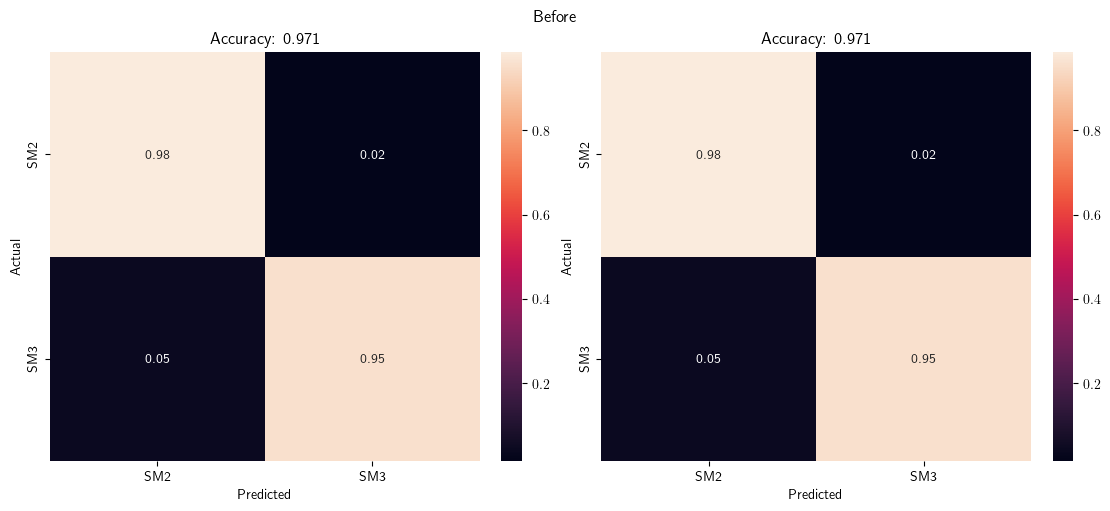

In [12]:
clf = LogisticRegression(penalty="l1", solver="saga", max_iter=10000, random_state=seed, n_jobs=-1)
clf.fit(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx + z_std_idx], metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_recorder_model"])

metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred"] = clf.predict(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx + z_std_idx])
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"] = clf.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx + z_std_idx])
metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred_recorder_model"] = [recorders[i] for i in clf.predict(metadata.loc[(sm2_idx | sm3_idx)  & train_idx, z_mean_idx + z_std_idx])]
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred_recorder_model"] = [recorders[i] for i in clf.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx + z_std_idx])]

plot_confusion_matrix(
    metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_recorder_model"].astype(int),
    metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"].astype(int),
    recorders,
    ax=ax1,
)

rf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf.fit(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx + z_std_idx], metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_recorder_model"])

plot_confusion_matrix(
    metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_recorder_model"].astype(int),
    metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"].astype(int), 
    recorders,
    ax=ax2,
)

metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred"] = rf.predict(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx + z_std_idx])
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"] = rf.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx + z_std_idx])
metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred_recorder_model"] = [recorders[i] for i in rf.predict(metadata.loc[(sm2_idx | sm3_idx)  & train_idx, z_mean_idx + z_std_idx])]
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred_recorder_model"] = [recorders[i] for i in rf.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx + z_std_idx])]

fig.suptitle("Before")
plt.savefig(assets_dir / 'recorder_predict_linear.jpg', dpi=1000)
plt.show()

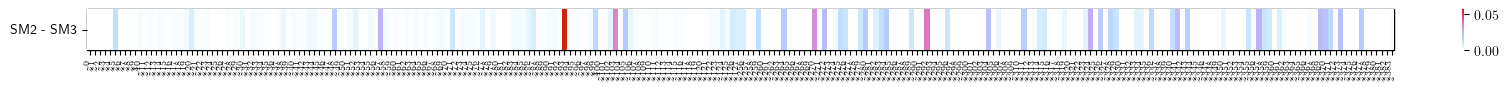

In [13]:
fig = plt.figure(figsize=(15, 0.8), constrained_layout=True)
ax = fig.add_subplot(111)
plot_feature_importance(
    data=pairwise_feature_importance(
        data=metadata,
        weights=clf.coef_,
        labels=[["SM2", "SM3"]],
        group_by="recorder_model",
        feature_columns=z_mean_idx + z_std_idx,
    ),
    y_tick_labels=["SM2 - SM3"],
    ax=ax,
)
ax.set_yticklabels(["SM2 - SM3"])
ax.set_xticklabels(z_mean_idx + z_std_idx, rotation=90)
plt.show()

### 2D Projection

In [14]:
mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2).fit(metadata.loc[:, z_mean_idx])
metadata.loc[:, "x_i"], metadata.loc[:, "y_i"] = np.hsplit(mapper.transform(metadata.loc[:, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[uk_idx, z_mean_idx])
metadata.loc[uk_idx, "uk_x_i"], metadata.loc[uk_idx, "uk_y_i"] = np.hsplit(mapper.transform(metadata.loc[uk_idx, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[ec_idx, z_mean_idx])
metadata.loc[ec_idx, "ec_x_i"], metadata.loc[ec_idx, "ec_y_i"] = np.hsplit(mapper.transform(metadata.loc[ec_idx, z_mean_idx]), 2)

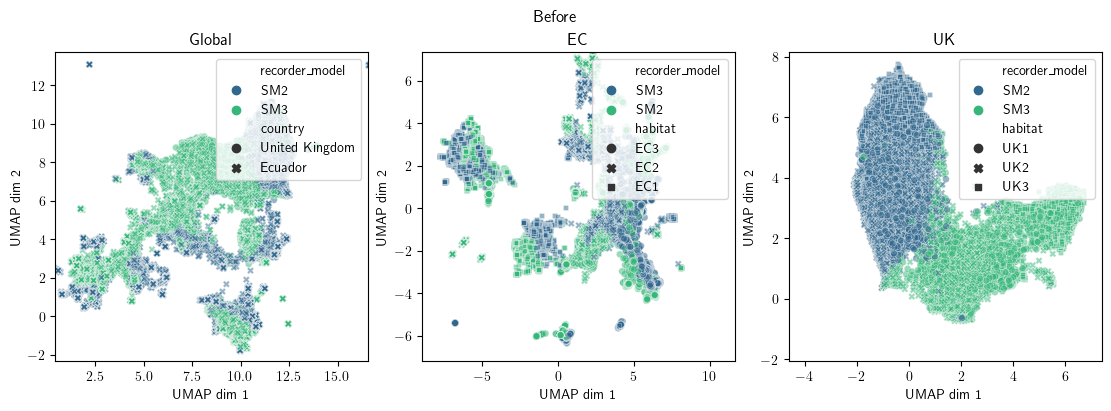

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), constrained_layout=True)

ax = axes[0]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "x_i"].mean(), metadata.loc[:, "x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "y_i"].mean(), metadata.loc[:, "y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata,
    x='x_i', y="y_i", 
    hue="recorder_model",
    style='country',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("Global")
sns.move_legend(ax, loc="upper right", ncols=1)


ax = axes[1]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "ec_x_i"].mean(), metadata.loc[:, "ec_x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "ec_y_i"].mean(), metadata.loc[:, "ec_y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[ec_idx],
    x='ec_x_i', y="ec_y_i", 
    hue="recorder_model",
    style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("EC")
sns.move_legend(ax, loc="upper right", ncols=1)

ax = axes[2]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "uk_x_i"].mean(), metadata.loc[:, "uk_x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "uk_y_i"].mean(), metadata.loc[:, "uk_y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_i', y="uk_y_i",
    hue="recorder_model",
    style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("UK")
sns.move_legend(ax, loc="upper right", ncols=1)

fig.suptitle("Before")
fig.savefig(assets_dir / 'chorus_before_recorder_umap.jpg', dpi=1000)

plt.show() 

In [16]:
z_sm2_mean = metadata.loc[sm2_idx, z_mean_idx].to_numpy()
sm2_mean = z_sm2_mean.mean(axis=0)
z_sm3_mean = metadata.loc[sm3_idx, z_mean_idx].to_numpy()
sm3_mean = z_sm3_mean.mean(axis=0)

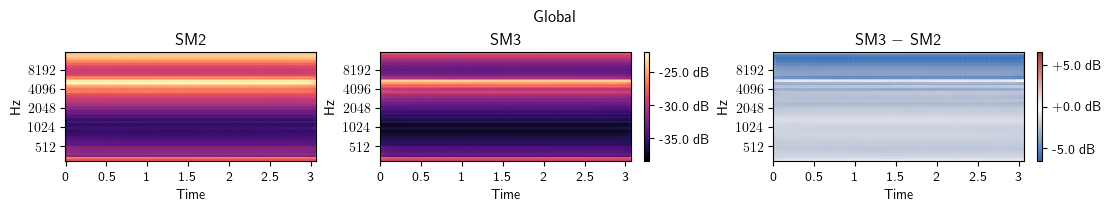

In [17]:
fig = plt.figure(figsize=(11, 8/4.0), constrained_layout=False)
grid = fig.add_gridspec(nrows=1, ncols=3)

recons = []
recorder_names = ["SM2", "SM3"]
vmin, vmax = np.inf, -np.inf
for z in [sm2_mean, sm3_mean]:
    with torch.no_grad():
        x_hat = decoder(torch.tensor(z).unsqueeze(0).unsqueeze(0).float())
        x_hat = x_hat.squeeze().t().exp().numpy()
    db = librosa.amplitude_to_db(x_hat)
    vmin = min(db.min(), vmin)
    vmax = max(db.max(), vmax)
    recons.append(x_hat)
    
    
for i, (recon, recorder_name) in enumerate(zip(recons, recorder_names)):
    ax = fig.add_subplot(grid[0, i])
    mesh = libd.specshow(
        librosa.amplitude_to_db(recon),
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cmap='magma',
        **specgram_params,
    )
    ax.set_title(recorder_name)
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)

residual = librosa.amplitude_to_db(recons[1]) - librosa.amplitude_to_db(recons[0])
upper_bound = max(residual.max(), abs(residual.min()))
norm = mpl.colors.TwoSlopeNorm(vmin=-upper_bound, vcenter=0.0, vmax=upper_bound)
ax = fig.add_subplot(grid[0, 2])
mesh = libd.specshow(
    residual,
    ax=ax,
    norm=norm,
    cmap=sns.color_palette("vlag", as_cmap=True),
    **specgram_params,
)
ax.set_title(r"SM3 $-$ SM2")
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)
plt.suptitle("Global")
plt.savefig(assets_dir / 'chorus_global_recorder_recon.jpg', dpi=1000)
plt.show()

In [18]:
global_sm2_mean = sm2_mean
global_sm3_mean = sm3_mean

Does this affect habitat prediction? First we predict habitat before:

Precision [0.81964697 0.84173809 0.88071206 0.91980663 0.88195892 0.90819318]
Recall [0.77800036 0.82319688 0.96404178 0.89598338 0.9281015  0.87759058]
F1 [0.79828086 0.83236425 0.92049487 0.90773872 0.90444207 0.89262966]
Precision [0.82206949 0.84868822 0.8787156  0.91978381 0.87542586 0.9044918 ]
Recall [0.78419231 0.81345029 0.96203294 0.89570637 0.92575188 0.87967795]
F1 [0.80268431 0.83069573 0.91848868 0.90758543 0.8998858  0.89191232]


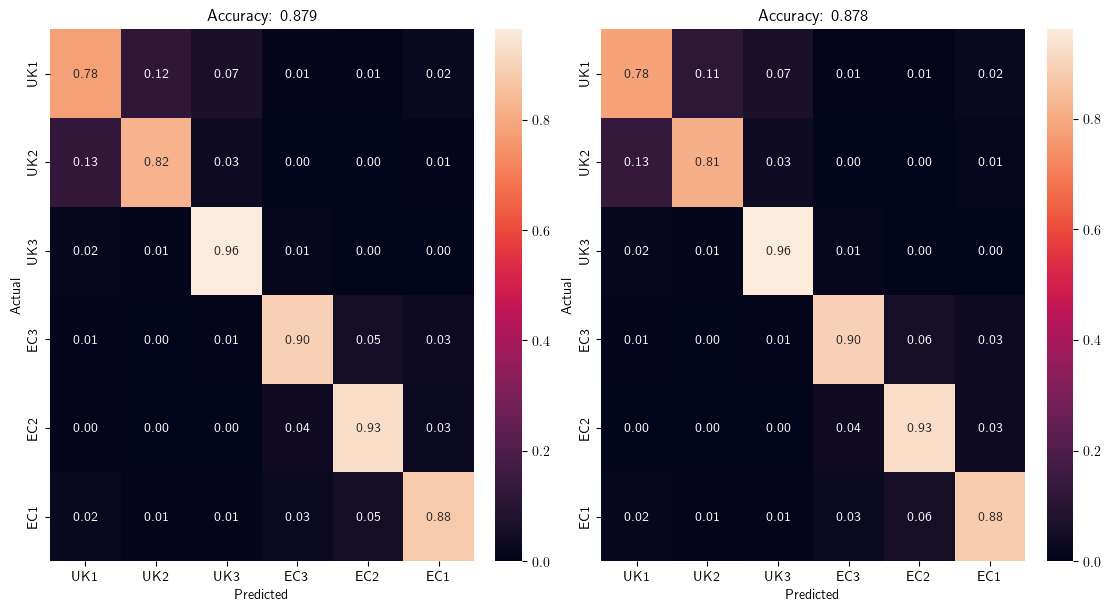

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5.5), constrained_layout=True)

# predict habitat
model = LogisticRegression(
    penalty="l1", 
    solver="saga",  
    max_iter=10000, 
    multi_class="multinomial",
    random_state=seed,
    n_jobs=-1
)
model.fit(metadata.loc[train_idx, z_mean_idx], metadata.loc[train_idx, "y_location"])
plot_confusion_matrix(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
    habitats,
    ax=axes[0]
)
prec, rec, f1, _ = metrics.precision_recall_fscore_support(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
)
print("Precision", prec)
print("Recall", rec)
print("F1", f1)

# apply the attribute vector
metadata.loc[sm2_idx, z_mean_idx] = z_sm2_mean - sm2_mean + sm3_mean

# predict habitat with adjusted representations
model = LogisticRegression(
    penalty="l1", 
    solver="saga",  
    max_iter=10000, 
    multi_class="multinomial",
    random_state=seed,
    n_jobs=-1
)
model.fit(metadata.loc[train_idx, z_mean_idx], metadata.loc[train_idx, "y_location"])
plot_confusion_matrix(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
    habitats,
    ax=axes[1],
)
prec, rec, f1, _ = metrics.precision_recall_fscore_support(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
)
print("Precision", prec)
print("Recall", rec)
print("F1", f1)

fig.savefig(assets_dir / '3s_chorus_habitat_pred.jpg', dpi=1000)
plt.show()

Prediction sees a 0.1% percent drop.

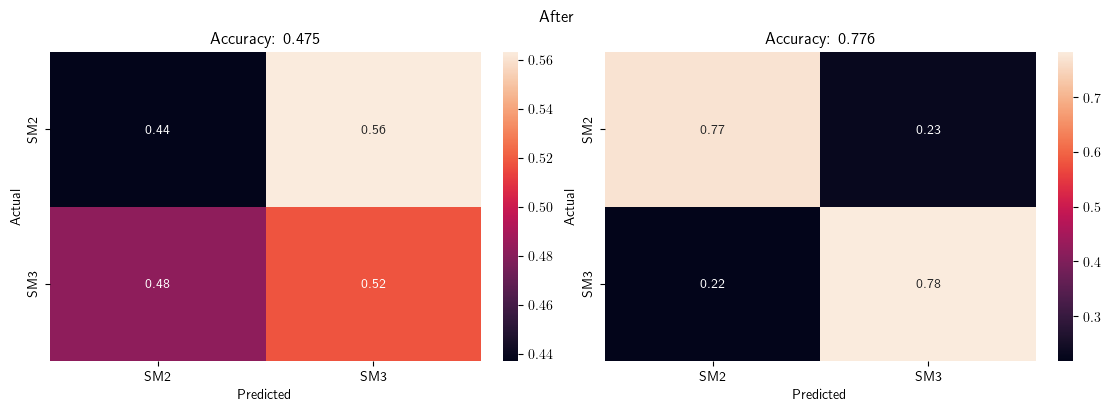

In [25]:
fig = plt.figure(figsize=(11, 4), constrained_layout=False)
ax1, ax2 = fig.subplots(nrows=1, ncols=2)

model = LogisticRegression(penalty="l1", solver="saga", max_iter=10000, random_state=seed, n_jobs=-1)
model.fit(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx], metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_recorder_model"])

metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred"] = model.predict(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx])
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"] = model.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx])
metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred_recorder_model"] = [recorders[i] for i in model.predict(metadata.loc[(sm2_idx | sm3_idx)  & train_idx, z_mean_idx])]
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred_recorder_model"] = [recorders[i] for i in model.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx])]

plot_confusion_matrix(
    metadata.loc[(sm2_idx | sm3_idx)  & test_idx, "y_recorder_model"].astype(int),
    metadata.loc[(sm2_idx | sm3_idx)  & test_idx, "y_pred"].astype(int),
    recorders,
    ax=ax1,
)

model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx], metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_recorder_model"])

metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred"] = model.predict(metadata.loc[(sm2_idx | sm3_idx) & train_idx, z_mean_idx])
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred"] = model.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx])
metadata.loc[(sm2_idx | sm3_idx) & train_idx, "y_pred_recorder_model"] = [recorders[i] for i in model.predict(metadata.loc[(sm2_idx | sm3_idx)  & train_idx, z_mean_idx])]
metadata.loc[(sm2_idx | sm3_idx) & test_idx, "y_pred_recorder_model"] = [recorders[i] for i in model.predict(metadata.loc[(sm2_idx | sm3_idx)  & test_idx, z_mean_idx])]

plot_confusion_matrix(
    metadata.loc[(sm2_idx | sm3_idx)  & test_idx, "y_recorder_model"].astype(int),
    metadata.loc[(sm2_idx | sm3_idx)  & test_idx, "y_pred"].astype(int), 
    recorders,
    ax=ax2,
)

fig.suptitle("After")
plt.savefig(assets_dir / 'recorder_predict_nonlinear.jpg', dpi=1000)
plt.show()

We have removed recorder effectively from the representation from a linear prediction task, however a non-linear model can still predict the recorder model.

In [26]:
mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2).fit(metadata.loc[:, z_mean_idx])
metadata.loc[:, "x_j"], metadata.loc[:, "y_j"] = np.hsplit(mapper.transform(metadata.loc[:, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[uk_idx, z_mean_idx])
metadata.loc[uk_idx, "uk_x_j"], metadata.loc[uk_idx, "uk_y_j"] = np.hsplit(mapper.transform(metadata.loc[uk_idx, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[ec_idx, z_mean_idx])
metadata.loc[ec_idx, "ec_x_j"], metadata.loc[ec_idx, "ec_y_j"] = np.hsplit(mapper.transform(metadata.loc[ec_idx, z_mean_idx]), 2)

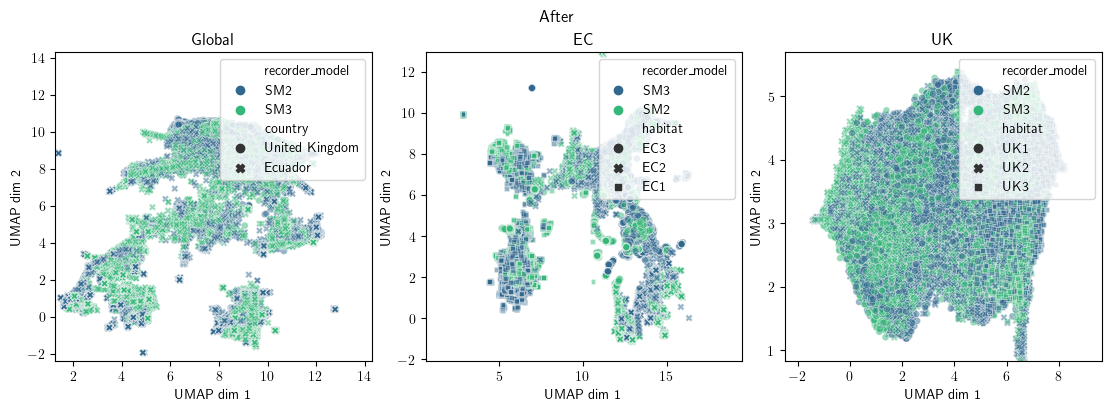

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), constrained_layout=True)

ax = axes[0]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "x_j"].mean(), metadata.loc[:, "x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "y_j"].mean(), metadata.loc[:, "y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata,
    x='x_j', y="y_j", 
    hue="recorder_model",
    style='country',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax,
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("Global")
sns.move_legend(ax, loc="upper right", ncols=1)


ax = axes[1]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "ec_x_j"].mean(), metadata.loc[:, "ec_x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "ec_y_j"].mean(), metadata.loc[:, "ec_y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[ec_idx],
    x='ec_x_j', y="ec_y_j", 
    hue="recorder_model",
    style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax,
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("EC")
sns.move_legend(ax, loc="upper right", ncols=1)

ax = axes[2]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "uk_x_j"].mean(), metadata.loc[:, "uk_x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "uk_y_j"].mean(), metadata.loc[:, "uk_y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_j', y="uk_y_j",
    hue="recorder_model",
    style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax,
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("UK")
sns.move_legend(ax, loc="upper right", ncols=1)

fig.suptitle("After")
fig.savefig(assets_dir / 'chorus_after_recorder_umap.svg')
fig.savefig(assets_dir / 'chorus_after_recorder_umap.png', dpi=400)

plt.show() 

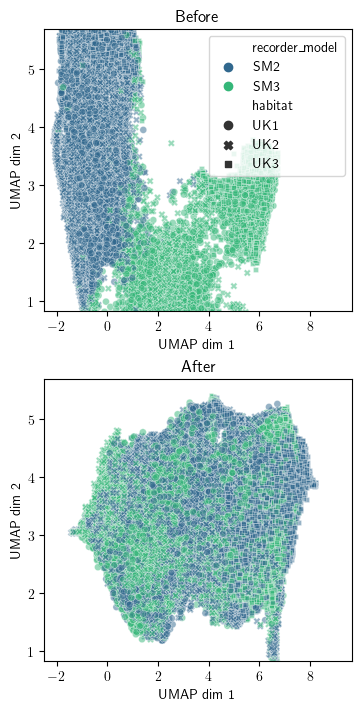

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 7), constrained_layout=True)

ax = axes[0]
sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_i', y="uk_y_i",
    hue="recorder_model", style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax,
    legend=True
)
ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("Before")
sns.move_legend(ax, loc="upper right", ncols=1)


ax = axes[1]
sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_j', y="uk_y_j",
    hue="recorder_model", style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax,
    legend=False
)
ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("After")

# fig.savefig(assets_dir / 'uk-remove-bimodality.png', dpi=400)

plt.show()

### By Country

Reset the data

In [33]:
metadata = dataset.metadata.merge(features, left_on="file_i", right_on="file_i", how="inner")

TRAIN, VAL, TEST = 0, 1, 2
train_idx = metadata.loc[:, "train/val/test"] == TRAIN
test_idx = (metadata.loc[:, "train/val/test"] == VAL) | (metadata.loc[:, "train/val/test"] == TEST)

num_frames, latent_dim = 19, 128

z_mean_idx = tuple(f"z_d={d}_t={t}" for t in range(num_frames) for d in range(latent_dim))
z_log_var_idx = tuple(f"z_d={d}_t={t}" for t in range(num_frames) for d in range(latent_dim, latent_dim * 2))

sm2_idx = metadata.recorder_no.isin(tuple(i for i in range(9, 17)))
sm3_idx = metadata.recorder_no.isin(tuple(i for i in range(1, 8)))
uk_idx = metadata.country == "United Kingdom"
ec_idx = metadata.country == "Ecuador"

metadata.loc[sm2_idx, "recorder_model"] = "SM2"
metadata.loc[sm3_idx, "recorder_model"] = "SM3"

y_habitat, habitats = metadata.habitat.factorize()
y_recorder_model, recorders = metadata[sm2_idx | sm3_idx].recorder_model.factorize()

metadata.loc[sm2_idx | sm3_idx, "y_recorder_model"] = y_recorder_model.astype(int)
metadata.loc[:, "y_location"] = y_habitat.astype(int)

label_columns = list(metadata.columns[0:28]) + ["recorder_model", "y_recorder_model", "y_location"]
data = []

for file_i, row in metadata.iterrows():
    labels = row[[*label_columns]]
    for t in range(num_frames):
        zs = tuple(fr"z_d={d}_t={t}" for d in range(latent_dim * 2))
        data.append([file_i, *labels, *list(row[[*zs]])])

z_mean_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim))
z_log_var_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim, latent_dim * 2))

columns = ["file_i", *label_columns, *z_mean_idx, *z_log_var_idx]
metadata = pd.DataFrame(data=data, columns=columns)

z_std_idx = tuple(fr"$z^{{{d}}}$" for d in range(latent_dim * 2, latent_dim * 3))
metadata.loc[:, z_std_idx] = np.exp(0.5 * metadata.loc[:, z_log_var_idx]).to_numpy()
metadata.loc[:, z_std_idx].head()

TRAIN, VAL, TEST = 0, 1, 2
train_idx = metadata.loc[:, "train/val/test"] == TRAIN
test_idx = (metadata.loc[:, "train/val/test"] == VAL) | (metadata.loc[:, "train/val/test"] == TEST)
sm2_idx = metadata.recorder_model == 'SM2'
sm3_idx = metadata.recorder_model == 'SM3'
uk_idx = metadata.country == "United Kingdom"
ec_idx = metadata.country == "Ecuador"

Run UMAP

In [34]:
mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2).fit(metadata.loc[:, z_mean_idx])
metadata.loc[:, "x_i"], metadata.loc[:, "y_i"] = np.hsplit(mapper.transform(metadata.loc[:, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[uk_idx, z_mean_idx])
metadata.loc[uk_idx, "uk_x_i"], metadata.loc[uk_idx, "uk_y_i"] = np.hsplit(mapper.transform(metadata.loc[uk_idx, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[ec_idx, z_mean_idx])
metadata.loc[ec_idx, "ec_x_i"], metadata.loc[ec_idx, "ec_y_i"] = np.hsplit(mapper.transform(metadata.loc[ec_idx, z_mean_idx]), 2)

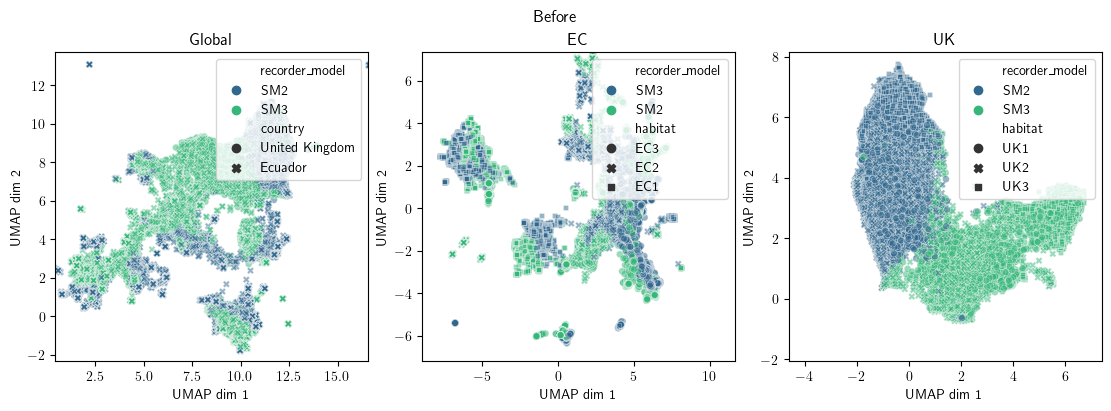

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), constrained_layout=True)

ax = axes[0]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "x_i"].mean(), metadata.loc[:, "x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "y_i"].mean(), metadata.loc[:, "y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata,
    x='x_i', y="y_i", 
    hue="recorder_model", style='country',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("Global")
sns.move_legend(ax, loc="upper right", ncols=1)


ax = axes[1]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "ec_x_i"].mean(), metadata.loc[:, "ec_x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "ec_y_i"].mean(), metadata.loc[:, "ec_y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[ec_idx],
    x='ec_x_i', y="ec_y_i", 
    hue="recorder_model", style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("EC")
sns.move_legend(ax, loc="upper right", ncols=1)

ax = axes[2]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "uk_x_i"].mean(), metadata.loc[:, "uk_x_i"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "uk_y_i"].mean(), metadata.loc[:, "uk_y_i"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_i', y="uk_y_i",
    hue="recorder_model", style='habitat',
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("UK")
sns.move_legend(ax, loc="upper right", ncols=1)

fig.suptitle("Before")
fig.savefig(assets_dir / 'chorus_before_recorder_by_country_umap.svg')
fig.savefig(assets_dir / 'chorus_before_recorder_by_country_umap.png', dpi=400)

plt.show() 

Compute recorder vectors by country

In [36]:
z_uk_sm2_mean = metadata.loc[uk_idx & sm2_idx, z_mean_idx].to_numpy()
uk_sm2_mean = z_uk_sm2_mean.mean(axis=0)

z_ec_sm2_mean = metadata.loc[ec_idx & sm2_idx, z_mean_idx].to_numpy()
ec_sm2_mean = z_ec_sm2_mean.mean(axis=0)

z_uk_sm3_mean = metadata.loc[uk_idx & sm3_idx, z_mean_idx].to_numpy()
uk_sm3_mean = z_uk_sm3_mean.mean(axis=0)

z_ec_sm3_mean = metadata.loc[ec_idx & sm3_idx, z_mean_idx].to_numpy()
ec_sm3_mean = z_ec_sm3_mean.mean(axis=0)

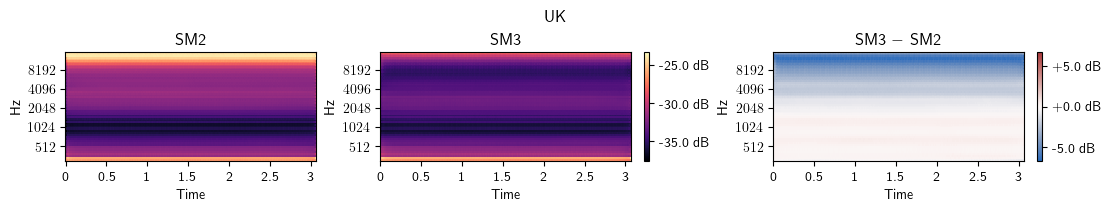

In [37]:
fig = plt.figure(figsize=(11, 8/4.0), constrained_layout=False)
grid = fig.add_gridspec(nrows=1, ncols=3)

recons = []
recorder_names = ["SM2", "SM3"]
vmin, vmax = np.inf, -np.inf
for z in [uk_sm2_mean, uk_sm3_mean]:
    with torch.no_grad():
        x_hat = decoder(torch.tensor(z).unsqueeze(0).unsqueeze(0).float())
        x_hat = x_hat.squeeze().t().exp().numpy()
    db = librosa.amplitude_to_db(x_hat)
    vmin = min(db.min(), vmin)
    vmax = max(db.max(), vmax)
    recons.append(x_hat)
    
for i, (recon, recorder_name) in enumerate(zip(recons, recorder_names)):
    ax = fig.add_subplot(grid[0, i])
    mesh = libd.specshow(
        librosa.amplitude_to_db(recon),
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cmap='magma',
        **specgram_params,
    )
    ax.set_title(recorder_name)
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)

import matplotlib as mpl

residual = librosa.amplitude_to_db(recons[1]) - librosa.amplitude_to_db(recons[0])
upper_bound = max(residual.max(), abs(residual.min()))
norm = mpl.colors.TwoSlopeNorm(vmin=-upper_bound, vcenter=0.0, vmax=upper_bound)
ax = fig.add_subplot(grid[0, 2])
mesh = libd.specshow(
    residual,
    ax=ax,
    norm=norm,
    cmap=sns.color_palette("vlag", as_cmap=True),
    **specgram_params,
)
ax.set_title(r"SM3 $-$ SM2")
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)
plt.suptitle("UK")
plt.savefig(assets_dir / 'chorus_uk_recorder_recon.png', dpi=400)
plt.show()

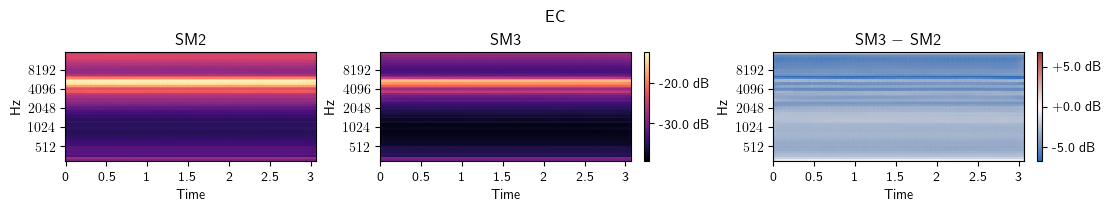

In [38]:
fig = plt.figure(figsize=(11, 8/4.0), constrained_layout=False)
grid = fig.add_gridspec(nrows=1, ncols=3)

recons = []
recorder_names = ["SM2", "SM3"]
vmin, vmax = np.inf, -np.inf
for z in [ec_sm2_mean, ec_sm3_mean]:
    with torch.no_grad():
        x_hat = decoder(torch.tensor(z).unsqueeze(0).unsqueeze(0).float())
        x_hat = x_hat.squeeze().t().exp().numpy()
    db = librosa.amplitude_to_db(x_hat)
    vmin = min(db.min(), vmin)
    vmax = max(db.max(), vmax)
    recons.append(x_hat)
    
for i, (recon, recorder_name) in enumerate(zip(recons, recorder_names)):
    ax = fig.add_subplot(grid[0, i])
    mesh = libd.specshow(
        librosa.amplitude_to_db(recon),
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cmap='magma',
        **specgram_params,
    )
    ax.set_title(recorder_name)
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)

import matplotlib as mpl

residual = librosa.amplitude_to_db(recons[1]) - librosa.amplitude_to_db(recons[0])
upper_bound = max(residual.max(), abs(residual.min()))
norm = mpl.colors.TwoSlopeNorm(vmin=-upper_bound, vcenter=0.0, vmax=upper_bound)
ax = fig.add_subplot(grid[0, 2])
mesh = libd.specshow(
    residual,
    ax=ax,
    norm=norm,
    cmap=sns.color_palette("vlag", as_cmap=True),
    **specgram_params,
)
ax.set_title(r"SM3 $-$ SM2")
plt.colorbar(mesh, format="%+3.1f dB", ax=ax)
plt.suptitle("EC")
plt.savefig(assets_dir / 'chorus_ec_recorder_recon.png', dpi=400)
plt.show()

In [39]:
def __scale_axes(axes, ax_type, which):
    """Set the axis scaling"""
    kwargs = dict()
    thresh = "linthresh"
    base = "base"
    scale = "linscale"

    if which == "x":
        scaler = axes.set_xscale
        limit = axes.set_xlim
    else:
        scaler = axes.set_yscale
        limit = axes.set_ylim

    # Map ticker scales
    if ax_type == "mel":
        mode = "symlog"
        kwargs[thresh] = 1000.0
        kwargs[base] = 2

    elif ax_type in [
        "cqt",
        "cqt_hz",
        "cqt_note",
        "cqt_svara",
        "vqt_hz",
        "vqt_note",
        "vqt_fjs",
    ]:
        mode = "log"
        kwargs[base] = 2

    elif ax_type in ["log", "fft_note", "fft_svara"]:
        mode = "symlog"
        kwargs[base] = 2
        kwargs[thresh] = float(core.note_to_hz("C2"))
        kwargs[scale] = 0.5

    elif ax_type in ["tempo", "fourier_tempo"]:
        mode = "log"
        kwargs[base] = 2
        limit(16, 480)
    else:
        return

    scaler(mode, **kwargs)

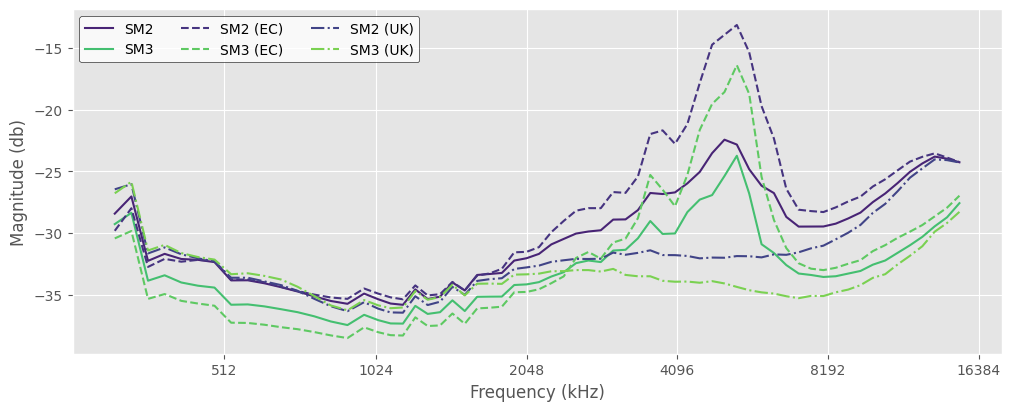

In [42]:
plt.style.use("ggplot")

labels = [r"SM2", r"SM3", r"SM2 (EC)", r"SM3 (EC)", r"SM2 (UK)",  r"SM3 (UK)"]
zs = [global_sm2_mean, global_sm3_mean, ec_sm2_mean, ec_sm3_mean, uk_sm2_mean, uk_sm3_mean]
line_styles = ["-", "-", "--", "--", '-.', '-.']
cmap = sns.color_palette("viridis", as_cmap=True)
a = cmap(np.linspace(0.1, 0.2, 3))
b = cmap(np.linspace(0.7, 0.8, 3))
colors = [[a[i], b[i]] for i in range(3)]
colors = [item for sublist in colors for item in sublist]

vmin = np.inf
vmax = -np.inf
dbs = []
for z in zs:
    with torch.no_grad():
        x_hat = decoder(torch.tensor(z).unsqueeze(0).unsqueeze(0).float())
        x_hat = x_hat.squeeze().t().exp().numpy()
    db = librosa.amplitude_to_db(x_hat)
    vmin = min(db.min(), vmin)
    vmax = max(db.max(), vmax)
    dbs.append(db.mean(axis=1))
ys = np.stack(dbs)

import scipy
import matplotlib.ticker as mplticker

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
xs = librosa.mel_frequencies(n_mels=64, fmin=150.0, fmax=15000, htk=False)
for i in range(6):
    ax.plot(xs, ys[i], linestyle=line_styles[i], label=labels[i], color=colors[i])

ax.set_xscale("symlog", linthresh=1000.0, base=2)
ax.xaxis.set_major_formatter(mplticker.ScalarFormatter())
ax.xaxis.set_major_locator(mplticker.SymmetricalLogLocator(ax.xaxis.get_transform()))
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Magnitude (db)')

legend = plt.legend(
    ncols=len(labels)//2,
    loc="upper left",
#     bbox_to_anchor=(0.5, 1.18),
    edgecolor=(0, 0, 0, 1.), 
    facecolor=(1, 1, 1, 0.1),
)

fig.savefig(assets_dir / 'recorder_response_curve.jpg', dpi=1000)

plt.show()

plt.style.use("default")

Subtract recorder by country

In [43]:
metadata.loc[uk_idx & sm2_idx, z_mean_idx] = z_uk_sm2_mean - uk_sm2_mean + uk_sm3_mean
metadata.loc[ec_idx & sm2_idx, z_mean_idx] = z_ec_sm2_mean - ec_sm2_mean + ec_sm3_mean

In [44]:
mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2).fit(metadata.loc[:, z_mean_idx])
metadata.loc[:, "x_j"], metadata.loc[:, "y_j"] = np.hsplit(mapper.transform(metadata.loc[:, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[uk_idx, z_mean_idx])
metadata.loc[uk_idx, "uk_x_j"], metadata.loc[uk_idx, "uk_y_j"] = np.hsplit(mapper.transform(metadata.loc[uk_idx, z_mean_idx]), 2)

mapper = UMAP(metric="euclidean", n_neighbors=50, min_dist=0.0, random_state=seed, n_components=2, n_jobs=-1).fit(metadata.loc[ec_idx, z_mean_idx])
metadata.loc[ec_idx, "ec_x_j"], metadata.loc[ec_idx, "ec_y_j"] = np.hsplit(mapper.transform(metadata.loc[ec_idx, z_mean_idx]), 2)

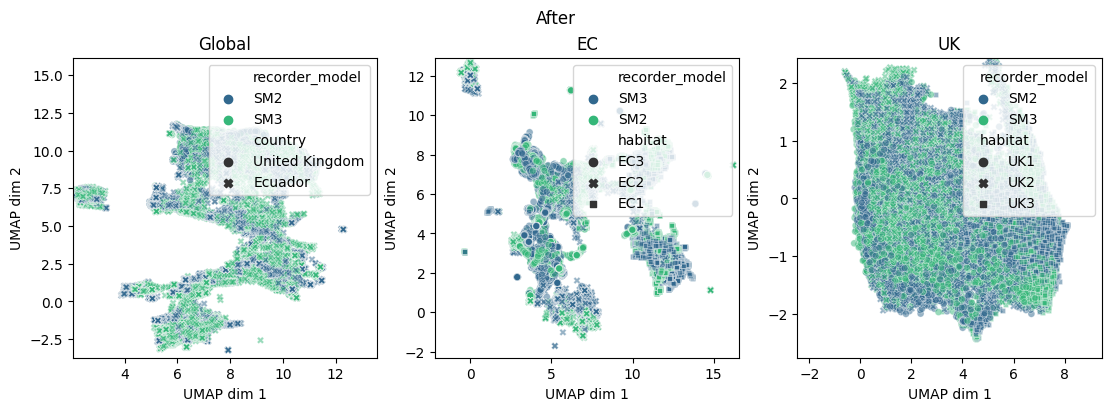

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), constrained_layout=True)

ax = axes[0]
z_score = 2.5
x_mean, x_std = metadata.loc[:, "x_j"].mean(), metadata.loc[:, "x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "y_j"].mean(), metadata.loc[:, "y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata, 
    x='x_j', y="y_j",
    hue="recorder_model",
    style="country",
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", 2), 
    ax=ax
)
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("Global")
sns.move_legend(ax, loc='upper right', ncol=1)

ax = axes[1]

z_score = 2.5
x_mean, x_std = metadata.loc[:, "ec_x_j"].mean(), metadata.loc[:, "ec_x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "ec_y_j"].mean(), metadata.loc[:, "ec_y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[ec_idx],
    x='ec_x_j', y="ec_y_j",
    hue="recorder_model", style="habitat",
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("EC")
sns.move_legend(ax, loc="upper right", ncols=1)

ax = axes[2]

z_score = 2.5
x_mean, x_std = metadata.loc[:, "uk_x_j"].mean(), metadata.loc[:, "uk_x_j"].std()
x_min = x_mean - z_score * x_std
x_max = x_mean + z_score * x_std
y_mean, y_std = metadata.loc[:, "uk_y_j"].mean(), metadata.loc[:, "uk_y_j"].std()
y_min = y_mean - z_score * y_std
y_max = y_mean + z_score * y_std

sns.scatterplot(
    data=metadata[uk_idx],
    x='uk_x_j', y="uk_y_j", 
    hue="recorder_model", style="habitat",
    s=25, alpha=0.5,
    palette=sns.color_palette("viridis", n_colors=2),
    ax=ax
)

ax.set_xlim([x_min.min(), x_max.max()])
ax.set_ylim([y_min.min(), y_max.max()])
ax.set_xlabel(r"UMAP dim 1")
ax.set_ylabel(r"UMAP dim 2")
ax.set_title("UK")

# sns.move_legend(ax, loc="upper right", ncols=1)
fig.suptitle("After")

fig.savefig(assets_dir / 'chorus_after_recorder_by_country_umap.jpeg', dpi=1000)

plt.show() 

Precision [0.79492683 0.8056872  0.85343896 0.8705728  0.83501127 0.81010374]
Recall [0.74194136 0.79532164 0.95218963 0.82728532 0.87045739 0.80333979]
F1 [0.76752072 0.80047087 0.90011394 0.84837725 0.85236598 0.80670759]


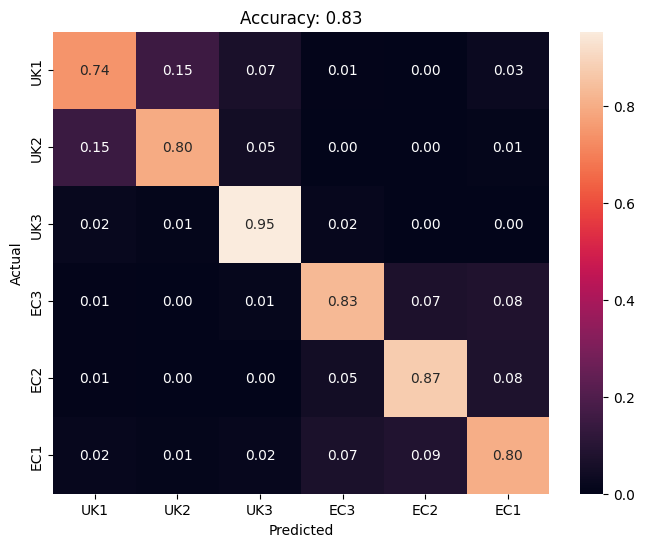

In [47]:
model = LogisticRegression(
    penalty="l1", 
    solver="saga",  
    max_iter=10000, 
    multi_class="multinomial",
    random_state=seed,
    n_jobs=-1
)
model.fit(metadata.loc[train_idx, z_mean_idx], metadata.loc[train_idx, "y_location"])
plot_confusion_matrix(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
    habitats
)
plt.savefig(assets_dir / 'habitat_pred_after_removing_recorder_by_country.png', dpi=200)
prec, rec, f1, _ = metrics.precision_recall_fscore_support(
    metadata.loc[test_idx, "y_location"].astype(int),
    model.predict(metadata.loc[test_idx, z_mean_idx]).astype(int),
)
print("Precision", prec)
print("Recall", rec)
print("F1", f1)
plt.show()

Decrease in accuracy of 4%, due to means being adjusted by country, reducing errors across country and increasing errors within country.

Look at UMAP recorder split by site

In [53]:
metadata = dataset.metadata.merge(features, left_on="file_i", right_on="file_i", how="inner")
z_mean_idx = tuple(f"z_d={d}_t={t}" for t in range(num_frames) for d in range(latent_dim))
sm2_idx = metadata.recorder_no.isin(tuple(i for i in range(9, 17)))
sm3_idx = metadata.recorder_no.isin(tuple(i for i in range(1, 8)))
uk_idx = metadata.country == "United Kingdom"
ec_idx = metadata.country == "Ecuador"
metadata.loc[sm2_idx, "recorder_model"] = "SM2"
metadata.loc[sm3_idx, "recorder_model"] = "SM3"

UK1 34.10935604106635
UK2 -41.831260063219815
UK3 -137.93344583152793
EC1 79.39902272517793
EC2 2.0562189677730203
EC3 27.10157757543493


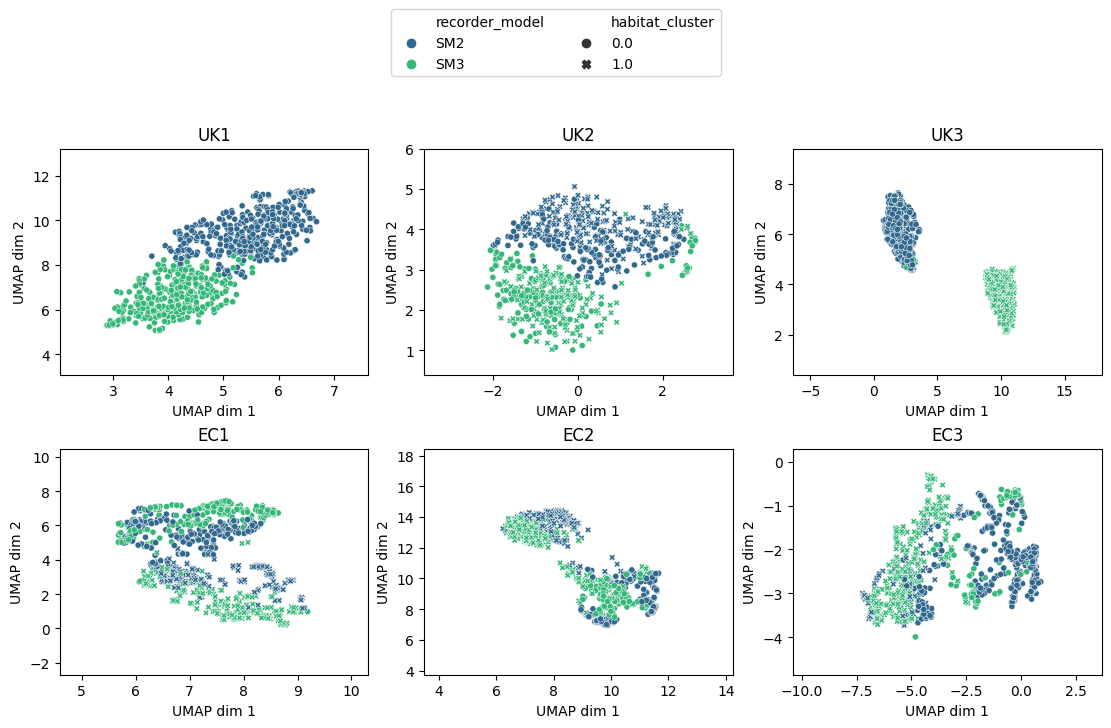

In [54]:
from sklearn.cluster import KMeans
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 6), constrained_layout=True)

for i, country in enumerate(["UK", "EC"]):
    for j, habitat in enumerate([f"{country}{k}" for k in range(1, 4)]):
        ax = axes[i, j]
        idx = metadata.habitat == habitat

        cluster = KMeans(n_clusters=2, random_state=42, init='k-means++', n_init="auto")
        cluster.fit(metadata.loc[idx, z_mean_idx])
        labels = cluster.labels_.astype(int)
        metadata.loc[idx, "habitat_cluster"] = labels
        centroids = cluster.cluster_centers_
        print(habitat, sum(centroids[0] - centroids[1]))

        embedding = UMAP(
            metric="euclidean",
            n_neighbors=50, 
            min_dist=0.0, 
            random_state=seed,
            n_components=2
        ).fit_transform(metadata.loc[idx, z_mean_idx])

        x, y = np.hsplit(embedding, 2)
        metadata.loc[idx, f"{habitat}_x"], metadata.loc[idx, f"{habitat}_y"] = x, y

        z_score = 3
        x_mean, x_std = metadata.loc[:, f"{habitat}_x"].mean(), metadata.loc[:, f"{habitat}_x"].std()
        x_min = x_mean - z_score * x_std
        x_max = x_mean + z_score * x_std
        y_mean, y_std = metadata.loc[:,f"{habitat}_y"].mean(), metadata.loc[:, f"{habitat}_y"].std()
        y_min = y_mean - z_score * y_std
        y_max = y_mean + z_score * y_std

        legend = (i * j == 2)
        sns.scatterplot(
            data=metadata, 
            x=f"{habitat}_x", y=f"{habitat}_y",
            hue="recorder_model",
            style="habitat_cluster",
            s=20, 
            palette=sns.color_palette("viridis", 2), 
            ax=ax,
            legend=legend,
        )
        if legend:
            ax.get_legend().remove()

        ax.set_xlim(left=x_min, right=x_max)
        ax.set_ylim(bottom=y_min, top=y_max)
        ax.set_xlabel(r"UMAP dim 1")
        ax.set_ylabel(r"UMAP dim 2")
        ax.set_title(habitat)

fig.legend(
    *ax.get_legend_handles_labels(),
    loc='upper center', 
    ncols=2, 
    bbox_to_anchor=(0.5, 1.2)
)

plt.show() 